<a href="https://colab.research.google.com/github/aimbsg/EVA4_S6/blob/master/3_EVA4S6_With_L2_No_L1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target - Along with batch normalization dropout(0.05) is added IN ALL LAYERS EXCEPT LAST LAYER and image augmentation is used. Global Average Pooling is introduced and expecting to hit 99.4% consistently.

Result - Best accuracy : 99.06%(train) 99.46%(test) ; Params : 8,936

Analysis - No overfit in the model is observed. Train accuracy is less than test accuracy complementing the use of regularization and augmentation strategies. Final few epochs are above 99.4% consistently. 

Regularization - Only L2 is used

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 1, 28, 28])
torch.Size([128])


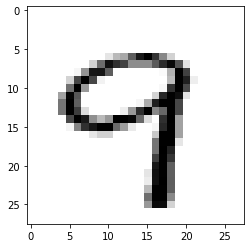

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

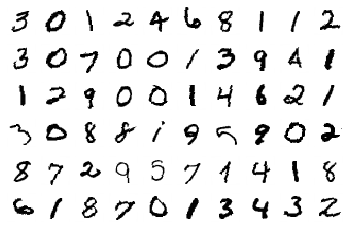

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             720
             ReLU-12            [-1, 8, 10, 10]               0
      BatchNorm2d-13            [-1, 8, 10, 10]              16
          Dropout-14            [-

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.6086723804473877 Batch_id=468 Accuracy=87.03: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5578, Accuracy: 9567/10000 (95.67%)

EPOCH: 1


Loss=0.6669513583183289 Batch_id=468 Accuracy=95.50: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5153, Accuracy: 9237/10000 (92.37%)

EPOCH: 2


Loss=0.5065134167671204 Batch_id=468 Accuracy=95.57: 100%|██████████| 469/469 [00:21<00:00, 21.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5559, Accuracy: 9594/10000 (95.94%)

EPOCH: 3


Loss=0.6588552594184875 Batch_id=468 Accuracy=95.73: 100%|██████████| 469/469 [00:21<00:00, 21.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6171, Accuracy: 9507/10000 (95.07%)

EPOCH: 4


Loss=0.5765934586524963 Batch_id=468 Accuracy=95.85: 100%|██████████| 469/469 [00:21<00:00, 21.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5681, Accuracy: 9674/10000 (96.74%)

EPOCH: 5


Loss=0.6260946989059448 Batch_id=468 Accuracy=95.86: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5961, Accuracy: 9461/10000 (94.61%)

EPOCH: 6


Loss=0.6129801869392395 Batch_id=468 Accuracy=95.83: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5264, Accuracy: 9649/10000 (96.49%)

EPOCH: 7


Loss=0.64275723695755 Batch_id=468 Accuracy=95.92: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5519, Accuracy: 9602/10000 (96.02%)

EPOCH: 8


Loss=0.5629293918609619 Batch_id=468 Accuracy=95.94: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5020, Accuracy: 9643/10000 (96.43%)

EPOCH: 9


Loss=0.551121175289154 Batch_id=468 Accuracy=95.93: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6258, Accuracy: 9563/10000 (95.63%)

EPOCH: 10


Loss=0.5459355711936951 Batch_id=468 Accuracy=95.95: 100%|██████████| 469/469 [00:21<00:00, 21.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5073, Accuracy: 9677/10000 (96.77%)

EPOCH: 11


Loss=0.5304854512214661 Batch_id=468 Accuracy=95.88: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5809, Accuracy: 9632/10000 (96.32%)

EPOCH: 12


Loss=0.5790190100669861 Batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:21<00:00, 21.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6780, Accuracy: 9477/10000 (94.77%)

EPOCH: 13


Loss=0.5185100436210632 Batch_id=468 Accuracy=95.95: 100%|██████████| 469/469 [00:21<00:00, 26.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5627, Accuracy: 9632/10000 (96.32%)

EPOCH: 14


Loss=0.5382919907569885 Batch_id=468 Accuracy=96.00: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5482, Accuracy: 9726/10000 (97.26%)

EPOCH: 15


Loss=0.5899154543876648 Batch_id=468 Accuracy=95.93: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5890, Accuracy: 9425/10000 (94.25%)

EPOCH: 16


Loss=0.5463957190513611 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6152, Accuracy: 9557/10000 (95.57%)

EPOCH: 17


Loss=0.5787824392318726 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:22<00:00, 21.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6276, Accuracy: 9645/10000 (96.45%)

EPOCH: 18


Loss=0.5793575048446655 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:22<00:00, 21.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6450, Accuracy: 9343/10000 (93.43%)

EPOCH: 19


Loss=0.5927801728248596 Batch_id=468 Accuracy=96.01: 100%|██████████| 469/469 [00:22<00:00, 21.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5165, Accuracy: 9590/10000 (95.90%)

EPOCH: 20


Loss=0.591742217540741 Batch_id=468 Accuracy=95.94: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7635, Accuracy: 9005/10000 (90.05%)

EPOCH: 21


Loss=0.5402902960777283 Batch_id=468 Accuracy=95.83: 100%|██████████| 469/469 [00:21<00:00, 21.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5334, Accuracy: 9619/10000 (96.19%)

EPOCH: 22


Loss=0.6132321953773499 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:22<00:00, 26.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5924, Accuracy: 9295/10000 (92.95%)

EPOCH: 23


Loss=0.5769281983375549 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5398, Accuracy: 9677/10000 (96.77%)

EPOCH: 24


Loss=0.6114205121994019 Batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5994, Accuracy: 9322/10000 (93.22%)

EPOCH: 25


Loss=0.5799639225006104 Batch_id=468 Accuracy=95.90: 100%|██████████| 469/469 [00:22<00:00, 20.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5806, Accuracy: 9675/10000 (96.75%)

EPOCH: 26


Loss=0.5834982991218567 Batch_id=468 Accuracy=95.91: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5860, Accuracy: 9600/10000 (96.00%)

EPOCH: 27


Loss=0.5723250508308411 Batch_id=468 Accuracy=95.94: 100%|██████████| 469/469 [00:22<00:00, 20.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3546, Accuracy: 9753/10000 (97.53%)

EPOCH: 28


Loss=0.6789129376411438 Batch_id=468 Accuracy=95.95: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6359, Accuracy: 9547/10000 (95.47%)

EPOCH: 29


Loss=0.5554060935974121 Batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:23<00:00, 20.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6654, Accuracy: 8803/10000 (88.03%)

EPOCH: 30


Loss=0.5770026445388794 Batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:22<00:00, 20.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6917, Accuracy: 9208/10000 (92.08%)

EPOCH: 31


Loss=0.520625650882721 Batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:22<00:00, 20.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6883, Accuracy: 9446/10000 (94.46%)

EPOCH: 32


Loss=0.5447975993156433 Batch_id=468 Accuracy=96.03: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6461, Accuracy: 9456/10000 (94.56%)

EPOCH: 33


Loss=0.6283240914344788 Batch_id=468 Accuracy=95.96: 100%|██████████| 469/469 [00:21<00:00, 21.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4845, Accuracy: 9604/10000 (96.04%)

EPOCH: 34


Loss=0.6302424669265747 Batch_id=468 Accuracy=95.98: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6945, Accuracy: 9356/10000 (93.56%)

EPOCH: 35


Loss=0.601422905921936 Batch_id=468 Accuracy=95.95: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5053, Accuracy: 9588/10000 (95.88%)

EPOCH: 36


Loss=0.5573515295982361 Batch_id=468 Accuracy=95.96: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5095, Accuracy: 9510/10000 (95.10%)

EPOCH: 37


Loss=0.5821173787117004 Batch_id=468 Accuracy=95.94: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6212, Accuracy: 9721/10000 (97.21%)

EPOCH: 38


Loss=0.6138839721679688 Batch_id=468 Accuracy=95.98: 100%|██████████| 469/469 [00:21<00:00, 21.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5489, Accuracy: 9404/10000 (94.04%)

EPOCH: 39


Loss=0.6633296608924866 Batch_id=468 Accuracy=96.12: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]



Test set: Average loss: 0.7888, Accuracy: 9237/10000 (92.37%)



Text(0.5, 1.0, 'Test Accuracy')

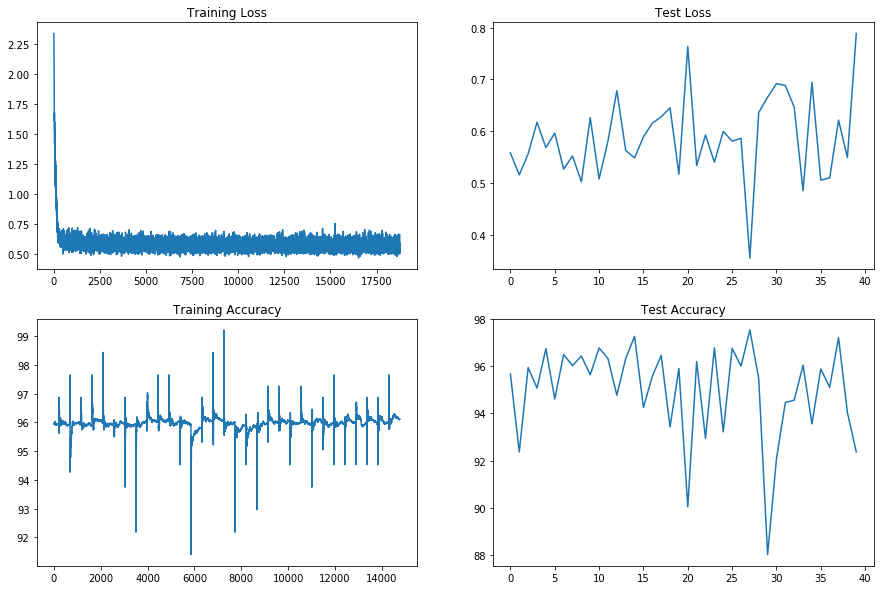

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
import numpy as np
def get_input_images(num):
    dataloader_args = dict(shuffle=True, batch_size=num, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)  
    test1 = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)  
    loader = torch.utils.data.DataLoader(test1, **dataloader_args)    
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [0]:
from torch.autograd import Variable
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

Input image : 


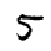

Predicted output :  8
Input image : 


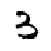

Predicted output :  8
Input image : 


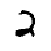

Predicted output :  8
Input image : 


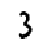

Predicted output :  8
Input image : 


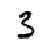

Predicted output :  8
Input image : 


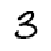

Predicted output :  8
Input image : 


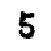

Predicted output :  8
Input image : 


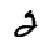

Predicted output :  8
Input image : 


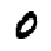

Predicted output :  8
Input image : 


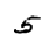

Predicted output :  8
Input image : 


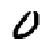

Predicted output :  8
Input image : 


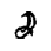

Predicted output :  8
Input image : 


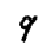

Predicted output :  8
Input image : 


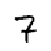

Predicted output :  8
Input image : 


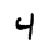

Predicted output :  8
Input image : 


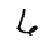

Predicted output :  4
Input image : 


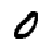

Predicted output :  8
Input image : 


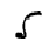

Predicted output :  8
Input image : 


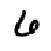

Predicted output :  8
Input image : 


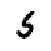

Predicted output :  8
Input image : 


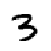

Predicted output :  8
Input image : 


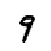

Predicted output :  8
Input image : 


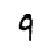

Predicted output :  8
Input image : 


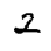

Predicted output :  8
Input image : 


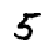

Predicted output :  8
Input :  tensor([1, 5, 3, 2, 3, 3, 3, 5, 2, 8, 0, 5, 0, 2, 9, 7, 4, 6, 0, 5, 8, 6, 5, 4,
        3, 9, 9, 2, 5, 2, 1, 2, 4, 3, 8, 5, 3, 4, 4, 9, 2, 4, 2, 8, 6, 5, 7, 0,
        3, 3, 5, 5, 8, 7, 6, 3, 1, 7, 8, 1, 4, 5, 2, 6, 2, 5, 5, 9, 4, 1, 9, 1,
        7, 0, 3, 4, 4, 4, 3, 7, 7, 0, 4, 9, 3, 1, 8, 6, 0, 2, 9, 2, 0, 7, 6, 7,
        4, 2, 1, 5])
Output :  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8]


In [15]:
to_pil = transforms.ToPILImage()
images, labels = get_input_images(100)

inc = 0
output = []
for ii in range(1, len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    output.append(index)
    res = int(labels[ii]) == index
    if(res == False):
      inc += 1
      plt.subplot(5, 6, ii)
      plt.axis('off')
      print("Input image : ")
      plt.imshow(images[ii].numpy().squeeze(), cmap='gray_r')
      plt.show()
      print("Predicted output : ",index)
    if(inc == 25):
      break
          
print("Input : ",labels)      
print("Output : ",output)        

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [17]:
import os
os.chdir('/content/gdrive/My Drive/EVA4S6_Train_Test_Accu_Loss')
os.getcwd()

'/content/gdrive/My Drive/EVA4S6_Train_Test_Accu_Loss'

In [0]:
torch.save(test_acc,'with_L2_no_L1_test_acc.pt')
torch.save(test_losses,'with_L2_no_L1_test_loss.pt')